#### Saving and Loading PyTorch Models

This is to some extend based on https://pytorch.org/tutorials/beginner/saving_loading_models.html

To reuse models after training, a nice functionality directly provided by PyTorch is the ability to save models on the GPU or CPU, or more specifically the paramaters of our models, into a file which we then can import again onto the CPU or GPU. First, let us build a model we want to save, here, we take some Regression MLP, in our special case, we are going to work with 2D data. 

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import OrderedDict
import re
import os
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

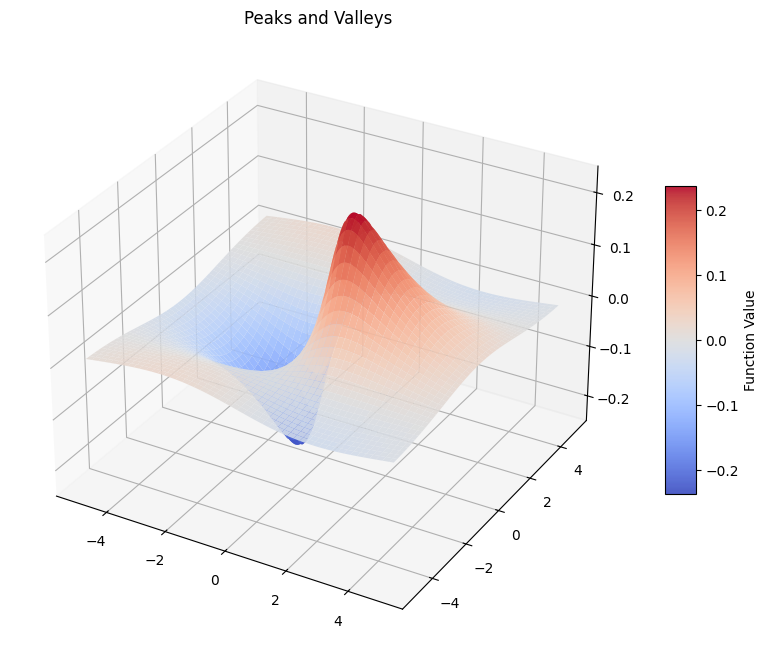

In [2]:
#first lets generate some data, lets look at a peaks and valleys dataset
n = 200

x = torch.linspace(-5, 5, n) 
X,Y = torch.meshgrid(x,x, indexing="ij") # data matrix 


inputs = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device) #this has shape [n*n,2], this is needed to efficiently optimize, dim = 1 means we combine column wise
labels = torch.sin(1/2 * X) * torch.cos(1/2 * Y)/(1+X**2+Y**2) #Labels_{i,j} = f(x_i,y_j), need this for showing the plot

#to visalize this dataset, we use mpl_toolkits for 3d plots, see https://matplotlib.org/stable/api/toolkits/mplot3d.html
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, labels, cmap='coolwarm', edgecolor='none', alpha=0.9)
ax.set_title("Peaks and Valleys")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Function Value')
plt.show()

labels = labels.flatten().view(-1,1).to(device) #due to the flatting, this has shape [n*n,1], needed for optimizing 

Model saved at epoch 0, loss: 0.20363542437553406
Model saved at epoch 5000, loss: 0.0029266357887536287
Model saved at epoch 10000, loss: 0.0026457104831933975
Model saved at epoch 15000, loss: 0.0023492660839110613
Model saved at epoch 20000, loss: 0.0020082995761185884
Model saved at epoch 25000, loss: 0.0016395816346630454
Model saved at epoch 30000, loss: 0.0012784709688276052
Model saved at epoch 35000, loss: 0.0009667935082688928
Model saved at epoch 40000, loss: 0.0007207542657852173
Model saved at epoch 45000, loss: 0.0005409673904068768
Model saved at epoch 50000, loss: 0.00041658192640170455
Model saved at epoch 55000, loss: 0.00033700582571327686
Model saved at epoch 60000, loss: 0.0002879491075873375
Model saved at epoch 65000, loss: 0.0002563241287134588
Model saved at epoch 70000, loss: 0.00023393619630951434
Model saved at epoch 75000, loss: 0.00021658265904989094
Model saved at epoch 80000, loss: 0.00020223582396283746
Model saved at epoch 85000, loss: 0.00018988132069

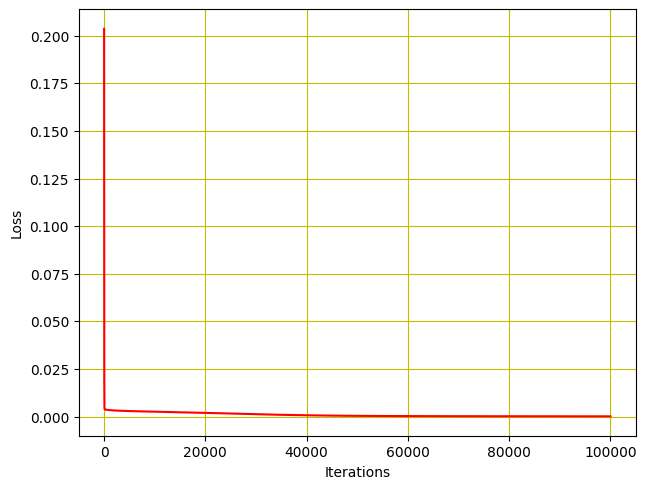

In [6]:
input_dim = 2
out_dim = 1
inner_dim1 = 6
inner_dim2 = 10
inner_dim3 = 14
inner_dim4 = 6
model =  nn.Sequential(OrderedDict([
('Layer1', nn.Linear(input_dim, inner_dim1)),
('act1', nn.Tanh()),
('Layer2', nn.Linear(inner_dim1, inner_dim2)),
('act2', nn.ReLU()),
('Layer3', nn.Linear(inner_dim2, inner_dim3)),
('act3', nn.ReLU()),
('Layer4', nn.Linear(inner_dim3, inner_dim4)),
('act4', nn.Tanh()),
('Outputlayer', nn.Linear(inner_dim4, out_dim)),
])).to(device)

lossfunction = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

lossovertime = []

saves = 0
iterations = 100000

for epoch in range(iterations):
    
    model.zero_grad()

    outputs = model(inputs)
    loss = lossfunction(outputs,labels)
    lossovertime.append(loss.item())
    loss.backward()
    optimizer.step()    
    
    #we can also save the model every 10000 to see how it evolves, how this saving works, see below. 
    if epoch % 5000 == 0:
        saves +=1 
        torch.save(model.state_dict(), f"Peaks and Valleys Model_{saves}.pt") 
        print(f"Model saved at epoch {epoch}, loss: {loss.item()}")
    
plt.plot(lossovertime, 'r')
plt.tight_layout()
plt.grid('True', color='y')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show() 

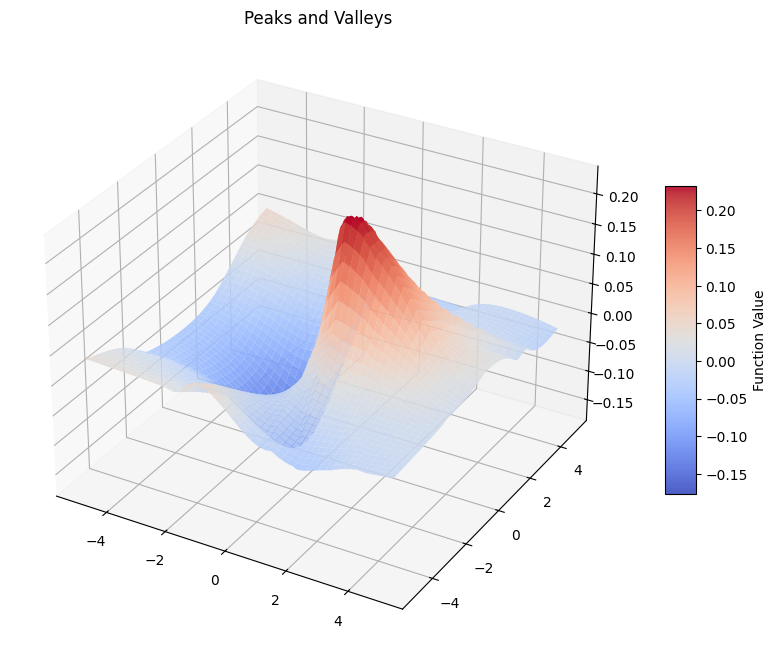

In [7]:
with torch.no_grad(): #does not add the eval to the graph
    outputs = model(inputs).reshape(n, n) #reshape to get back a matrix for the vis


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, outputs.detach().numpy(), cmap='coolwarm', edgecolor='none', alpha=0.9)
ax.set_title("Peaks and Valleys")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Function Value')
plt.show()

As we can see, the training of this model (on the CPU) actually takes some time, which is why saving might be a good idea when we actually want to use this again.

The basics of saving and loading can be done via `torch.save` and `torch.load`, they use the Python library https://docs.python.org/3/library/pickle.html which, via "Pickling" turns python object into binaries and via "Unpickling" does the reverse. Those two functions work on many things, like Tensors, Dictionaries etc. 

It is recommended to, instead of just saving `model.parameter()` you should save `model.state_dict()` which is easier to read. 

To again load the model, we have to define a model of the same architecture and then load the parameters as the weights using `model.load_state_dict()`

In case you want to load/save models onto the GPU or between different GPUs, see examples from https://pytorch.org/docs/stable/generated/torch.load.html.

torch.save(model.state_dict(), "Peaks and Valleys Model") # we can also save more informations, by packing the state dict into another dictionary with informations like amout of epochs, amount of datapoints etc.


In [8]:
def get_model(input_dim, inner_dim1, inner_dim2, inner_dim3, inner_dim4, out_dim):
    return nn.Sequential(OrderedDict([
        ('Layer1', nn.Linear(input_dim, inner_dim1)),
        ('act1', nn.Tanh()),
        ('Layer2', nn.Linear(inner_dim1, inner_dim2)),
        ('act2', nn.ReLU()),
        ('Layer3', nn.Linear(inner_dim2, inner_dim3)),
        ('act3', nn.ReLU()),
        ('Layer4', nn.Linear(inner_dim3, inner_dim4)),
        ('act4', nn.Tanh()),
        ('Outputlayer', nn.Linear(inner_dim4, out_dim)),
    ]))

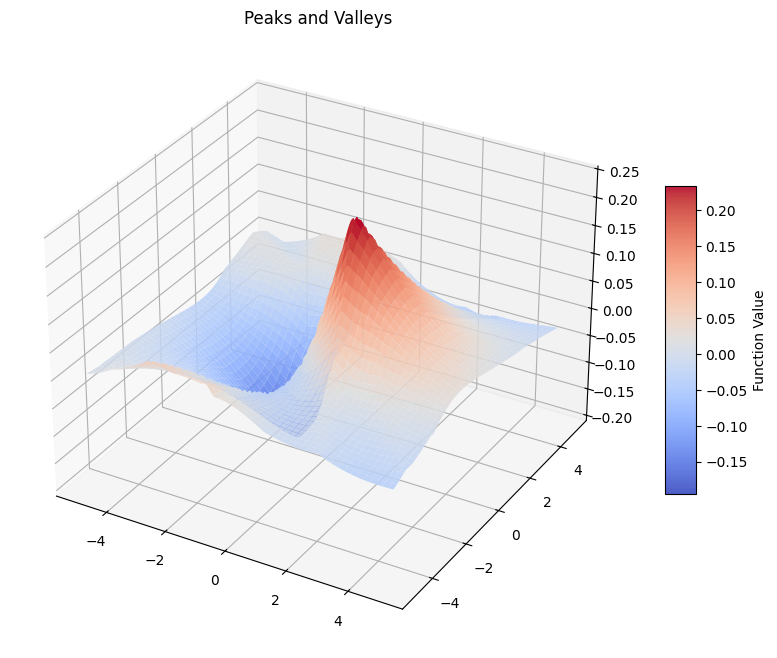

In [9]:
#Lets see what we get if we import our model. 
loaded_model =  get_model(input_dim, inner_dim1, inner_dim2, inner_dim3, inner_dim4, out_dim)

loaded_model.load_state_dict(torch.load("Peaks and Valleys Model", weights_only=True)) #weights_only=True so we only load Tensors, Dictionaries etc. - often used


with torch.no_grad(): #does not add the eval to the graph
    outputs = loaded_model(inputs).reshape(n, n).cpu() #reshape to get back a matrix for the vis


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, outputs.detach().numpy(), cmap='coolwarm', edgecolor='none', alpha=0.9)
ax.set_title("Peaks and Valleys")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Function Value')
plt.show()

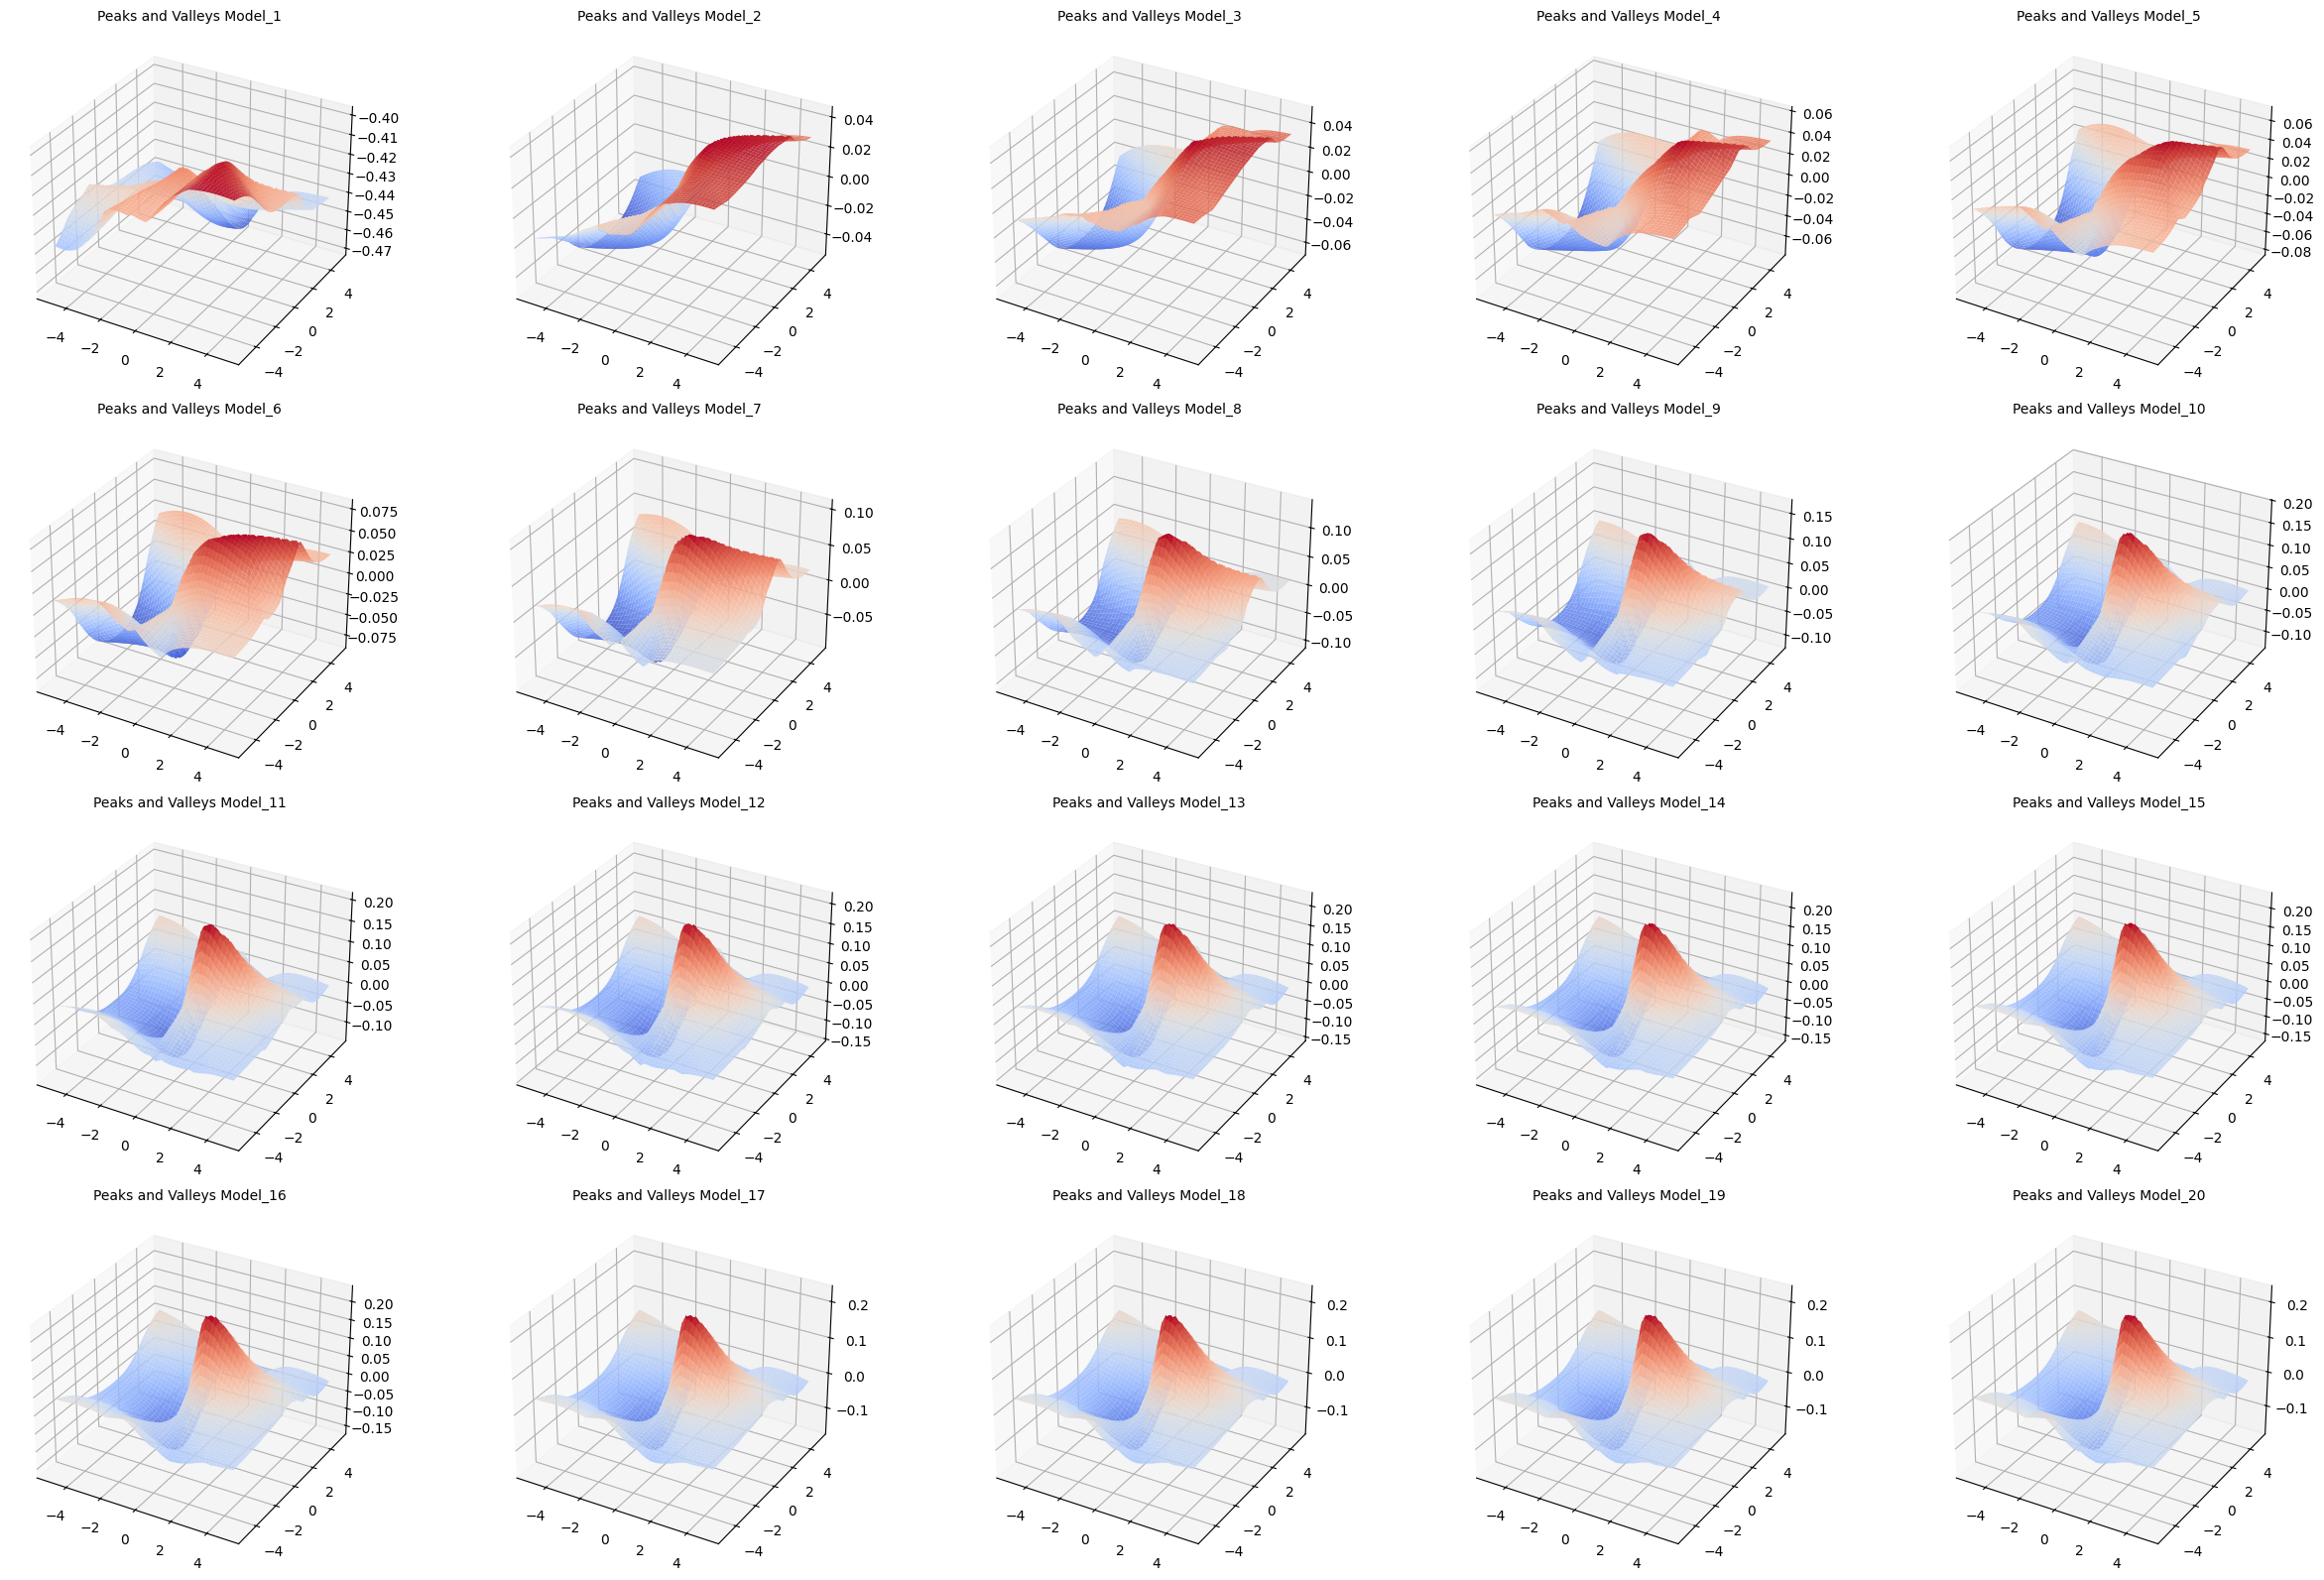

In [10]:
directory = './'  
pattern = r'Peaks and Valleys Model_(\d+)\.pt'  # filename pattern

model_files = sorted(
    [f for f in os.listdir(directory) if re.match(pattern, f)],
    key=lambda x: int(re.findall(r'\d+', x)[0])
)

num_models = len(model_files)
cols = math.ceil(math.sqrt(num_models))
rows = math.ceil(num_models / cols)

fig = plt.figure(figsize=(5 * cols, 4 * rows))

for idx, filename in enumerate(model_files):
    model = get_model(input_dim, inner_dim1, inner_dim2, inner_dim3, inner_dim4, out_dim).to(device)
    model.load_state_dict(torch.load(os.path.join(directory, filename), map_location=device, weights_only=True))
    model.eval()

    with torch.no_grad():
        output = model(inputs.to(device)).reshape(n, n).cpu() #get it on cpu

    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    surf = ax.plot_surface(X, Y, output.numpy(), cmap='coolwarm', edgecolor='none', alpha=0.9)
    ax.set_title(filename.replace('.pt', ''), fontsize=10)

# --- DISPLAY GRID ---
plt.tight_layout()
plt.show()